In [33]:
import pandas as pd
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

from pycaret.regression import *
from pycaret.regression import setup, compare_models

In [15]:
df = pd.read_csv("../data/clean/processed/df_model.csv")
print(df.shape)

(14632, 51)


In [3]:
pd.DataFrame({'columnas': df.columns})

,columnas
0,Name
1,Host Name
2,Host Location
3,Host Neighbourhood
4,Host Listings Count
5,Street
6,Zipcode
7,Market
8,Smart Location
9,Country Code


In [26]:
# === GENERACIÓN DE VARIABLES ===

# Combinar Guests Included con Availability para estimar potencial de ocupación
df['capacity_index'] = df['Guests Included'] * df['Availability 365']

# Confirmar que fue creada
print(" 'capacity_index' creada usando Guests Included × Availability 365")

✅ 'capacity_index' creada usando Guests Included × Availability 365


In [27]:
from sklearn.model_selection import train_test_split

# Separo variables predictoras y la variable objetivo
X = df.drop(columns='Price_log')
y = df['Price_log']

# Eliminar columnas no numéricas si quedan
non_numeric_cols = X.select_dtypes(include='object').columns.tolist()
if non_numeric_cols:
    print(f"Columnas no numéricas detectadas y eliminadas: {non_numeric_cols}")
    X = X.drop(columns=non_numeric_cols)

print(f" Conjuntos creados: X_train: {X_train.shape}, X_test: {X_test.shape}")

Columnas no numéricas detectadas y eliminadas: ['Name', 'Host Name', 'Host Location', 'Host Neighbourhood', 'Street', 'Zipcode', 'Market', 'Smart Location', 'Country Code', 'Country', 'Geolocation']
 Conjuntos creados: X_train: (11705, 39), X_test: (2927, 39)


 Conjuntos creados: X_train: (11705, 39), X_test: (2927, 39)


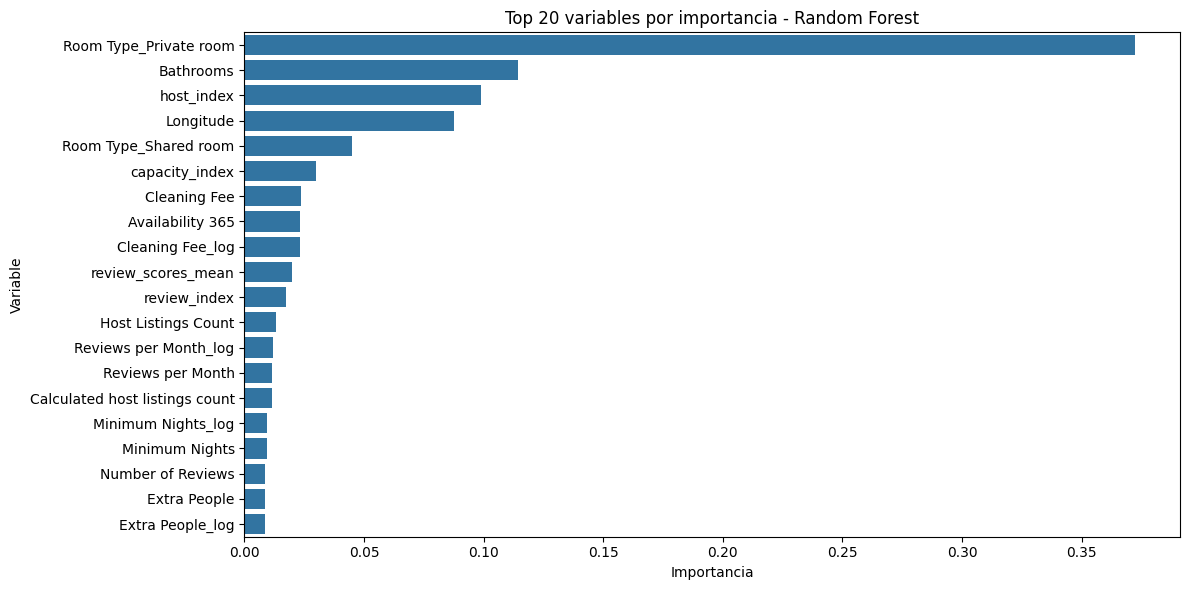

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f" Conjuntos creados: X_train: {X_train.shape}, X_test: {X_test.shape}")

# Entrenar modelo Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Importancia de variables
feature_importance = pd.DataFrame({
    'Variable': X_train.columns,
    'Importancia': rf.feature_importances_
}).sort_values('Importancia', ascending=False)

# Visualizar top 20
plt.figure(figsize=(12, 6))
sns.barplot(x='Importancia', y='Variable', data=feature_importance.head(20))
plt.title('Top 20 variables por importancia - Random Forest')
plt.tight_layout()
plt.show()

In [29]:
# Establezco un umbral de importancia
umbral = 0.005

# Selecciono las variables importantes
vars_seleccionadas = feature_importance[feature_importance['Importancia'] >= umbral]['Variable'].tolist()

# Filtrar X_train y X_test
X_train_sel = X_train[vars_seleccionadas]
X_test_sel = X_test[vars_seleccionadas]

print(f" Variables seleccionadas: {len(vars_seleccionadas)}")
print(f"X_train_sel: {X_train_sel.shape}, X_test_sel: {X_test_sel.shape}")

 Variables seleccionadas: 24
X_train_sel: (11705, 24), X_test_sel: (2927, 24)


In [39]:
# 1. Imports
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 2. División train/test (estratificando en 5 bins del target para equilibrar)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=pd.qcut(y, q=5, duplicates='drop')
)

# 3. Definición de modelos dentro de pipelines
models = {
    "LinearRegression": Pipeline([
        ("scaler", StandardScaler()),
        ("lr", LinearRegression())
    ]),
    "LassoCV": Pipeline([
        ("scaler", StandardScaler()),
        ("lasso", LassoCV(cv=5, random_state=42))
    ]),
    "RandomForest": Pipeline([
        ("scaler", StandardScaler()),
        ("rf", RandomForestRegressor(random_state=42))
    ]),
    "HistGradientBoosting": Pipeline([
        ("scaler", StandardScaler()),
        ("hgb", HistGradientBoostingRegressor(random_state=42))
    ])
}

# 4. Entrenamiento y evaluación en test
results = []
for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    results.append({
        "Modelo": name,
        "MAE": mean_absolute_error(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "R2": r2_score(y_test, y_pred)
    })

df_results = pd.DataFrame(results).sort_values("R2", ascending=False).reset_index(drop=True)
display(df_results)

,Modelo,MAE,MSE,RMSE,R2
0,RandomForest,0.254748,0.126376,0.355495,0.736977
1,HistGradientBoosting,0.262798,0.130485,0.361227,0.728426
2,LinearRegression,0.319804,0.202862,0.450403,0.577789
3,LassoCV,0.319470,0.203061,0.450623,0.577376


In [40]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    "rf__n_estimators": [100, 300, 500, 800],
    "rf__max_depth": [None, 10, 20, 30],
    "rf__min_samples_split": [2, 5, 10],
    "rf__min_samples_leaf": [1, 2, 4],
    "rf__max_features": ["auto", "sqrt", 0.3, 0.5]
}

rs_rf = RandomizedSearchCV(
    models["RandomForest"],
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    scoring="r2",
    n_jobs=-1,
    random_state=42
)
rs_rf.fit(X_train, y_train)
print("Mejores parámetros:", rs_rf.best_params_)
print("R² CV best:", rs_rf.best_score_)

Mejores parámetros: {'rf__n_estimators': 500, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 2, 'rf__max_features': 0.3, 'rf__max_depth': None}
R² CV best: 0.7292130701605073


In [30]:
# Defino modelos
modelos = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

# Cross Validation y evaluación para cada modelo
resultados = []

for nombre, modelo in modelos.items():
    print(f"\n Evaluando modelo: {nombre}")
    
    # Cross-validation (CV=5)
    cv = cross_validate(modelo, X_train_sel, y_train,
                        scoring=('r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_error'),
                        cv=5, return_train_score=False)

    # Promedios
    r2 = np.mean(cv['test_r2'])
    rmse = -np.mean(cv['test_neg_root_mean_squared_error'])
    mae = -np.mean(cv['test_neg_mean_absolute_error'])

    resultados.append({
        'Modelo': nombre,
        'R²': r2,
        'RMSE': rmse,
        'MAE': mae
    })

    print(f"R²: {r2:.4f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")

# Mostrar comparación
df_resultados = pd.DataFrame(resultados).sort_values('R²', ascending=False)
display(df_resultados)


 Evaluando modelo: Linear Regression
R²: 0.5737, RMSE: 0.45, MAE: 0.32

 Evaluando modelo: Random Forest
R²: 0.7227, RMSE: 0.36, MAE: 0.26


,Modelo,R²,RMSE,MAE
1,Random Forest,0.722716,0.363638,0.260113
0,Linear Regression,0.573678,0.451050,0.322837


In [34]:
reg_experiment = setup(
    data=df,
    target='Price_log',
    session_id=42,
    remove_multicollinearity=True,
    multicollinearity_threshold=0.95,
    normalize=True,
    verbose=False 
)

In [35]:
# 2. Comparar múltiples modelos automáticamente
best_model = compare_models()

# 3. Ver el modelo ganador y su rendimiento
print(best_model)

# 4. Opcional: evaluar, guardar o usar el modelo
evaluate_model(best_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
knn,K Neighbors Regressor,0.3035,0.1741,0.4172,0.6366,0.0827,0.0774,0.0760
et,Extra Trees Regressor,0.5471,0.4733,0.6879,0.0124,0.1370,0.1416,0.2970
par,Passive Aggressive Regressor,0.5465,0.4759,0.6897,0.0072,0.1374,0.1419,0.0760
xgboost,Extreme Gradient Boosting,0.5485,0.4793,0.6922,-0.0001,0.1375,0.1415,0.1170
huber,Huber Regressor,0.5488,0.4794,0.6923,-0.0002,0.1377,0.1419,0.1250
ridge,Ridge Regression,0.5487,0.4794,0.6923,-0.0004,0.1377,0.1419,0.0750
lightgbm,Light Gradient Boosting Machine,0.5488,0.4796,0.6925,-0.0008,0.1377,0.1420,0.5140
br,Bayesian Ridge,0.5488,0.4797,0.6925,-0.0010,0.1377,0.1419,0.0680
llar,Lasso Least Angle Regression,0.5488,0.4797,0.6925,-0.0010,0.1377,0.1419,0.0660
lar,Least Angle Regression,0.5488,0.4797,0.6925,-0.0010,0.1377,0.1419,0.0710


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

KNeighborsRegressor(n_jobs=-1)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [37]:
from pycaret.regression import *

# 1. Inicializa el entorno de trabajo (si no lo hiciste ya)
reg_experiment = setup(data=df, target='Price_log', session_id=42, normalize=True, verbose=False)

# 2. Crea el modelo base
rf_model = create_model('rf')

# 3. Ahora sí, lo puedes tunear
tuned_rf = tune_model(rf_model, optimize='R2')

# 4. Evaluar gráficamente
evaluate_model(tuned_rf)

# 5. Entrenar modelo final sobre todo el dataset
final_rf = finalize_model(tuned_rf)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.5409,0.4752,0.6894,-0.0022,0.1353,0.1373
1,0.5456,0.4756,0.6897,-0.0050,0.1363,0.1387
2,0.5468,0.4766,0.6904,0.0001,0.1376,0.1420
3,0.5682,0.5128,0.7161,0.0005,0.1422,0.1469
4,0.5372,0.4673,0.6836,-0.0008,0.1360,0.1395
5,0.5351,0.4539,0.6737,-0.0007,0.1355,0.1404
6,0.5551,0.4853,0.6967,-0.0006,0.1391,0.1445
7,0.5664,0.5026,0.7090,-0.0008,0.1417,0.1478
8,0.5486,0.4717,0.6868,-0.0025,0.1380,0.1442


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4237,0.3009,0.5486,0.3654,0.1088,0.1090
1,0.4191,0.2993,0.5471,0.3676,0.1080,0.1066
2,0.4070,0.2793,0.5285,0.4141,0.1075,0.1077
3,0.4212,0.2971,0.5451,0.4208,0.1095,0.1102
4,0.4007,0.2709,0.5205,0.4197,0.1044,0.1048
5,0.3814,0.2413,0.4912,0.4680,0.1009,0.1016
6,0.4157,0.2814,0.5305,0.4198,0.1081,0.1107
7,0.4495,0.3327,0.5768,0.3376,0.1170,0.1195
8,0.4282,0.2951,0.5432,0.3728,0.1103,0.1135


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…